# Two Sigma Connect: Rental Listing Inquiries

В нашем распоряжении данные объявлений об аренде квартир в Нью-Йорке

**Задача** - спрогнозировать степень интереса к объявлению со стороны арендаторов. А именно, вероятность принадлежности объявления к одному из трёх классов по степени интереса к нему: *низкий*, *средний*, *высокий*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from scipy import sparse
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

##  Анализ данных и создание признаков

In [2]:
train_df = pd.read_json(r"C:\Users\leoci\Desktop\Two_Sigma\train.json")
test_df = pd.read_json(r"C:\Users\leoci\Desktop\Two_Sigma\test.json")

In [3]:
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 124010
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        74659 non-null  float64
 1   bedrooms         74659 non-null  int64  
 2   building_id      74659 non-null  object 
 3   created          74659 non-null  object 
 4   description      74659 non-null  object 
 5   display_address  74659 non-null  object 
 6   features         74659 non-null  object 
 7   latitude         74659 non-null  float64
 8   listing_id       74659 non-null  int64  
 9   longitude        74659 non-null  float64
 10  manager_id       74659 non-null  object 
 11  photos           74659 non-null  object 
 12  price            74659 non-null  int64  
 13  street_address   74659 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 8.5+ MB


В датасете есть следующие столбцы:
- bathrooms - количество санузлов в квартире
- bedrooms - количество спален в квартире
- building_id - id здания
- created - дата публикации объявления
- description - описание квартиры
- display_address - адрес дома (только улица)
- features - отдельно отмеченные удобства в квартире
- latitude и longitude - координаты на карте
- listing_id - id объявления
- manager_id - id менеджера, размещающего объявление
- photos - ссылки на фотографии квартиры
- price - арендная стоимость
- street_address - адрес с указанием номера дома
- interest_level - уровень интереса к объявлению

Признак street_address повторяет адрес, указанный в display_address, но с указанием номера дома. Таким образом, этот признак, скорее всего, отражает ту же информацию, что и building_id. Поэтому мы этот признак учитывать не будем.

Рассмотрим все остальные признаки по отдельности.

### Численные признаки

1. **bathrooms**

In [6]:
train_df['bathrooms'].value_counts()

1.0     39422
2.0      7660
3.0       745
1.5       645
0.0       313
2.5       277
4.0       159
3.5        70
4.5        29
5.0        20
5.5         5
6.0         4
7.0         1
6.5         1
10.0        1
Name: bathrooms, dtype: int64

Основная масса квартир имеет 1-3 санузла. Объявления с количеством санузлов больше 6 выглядят подозрительно, и их очень мало. удалим их.

In [7]:
train_df = train_df.query("bathrooms <= 6")

2. **bedrooms**

In [8]:
train_df['bedrooms'].value_counts()

1    15752
2    14622
0     9475
3     7276
4     1929
5      246
6       46
8        2
7        1
Name: bedrooms, dtype: int64

Как и с санузлами, удалим квартиры-особняки, в которых больше 6 спален, т.к. их процент очень маленький.

In [9]:
train_df = train_df.query("bedrooms <= 6")

3. **latitude и longitude**

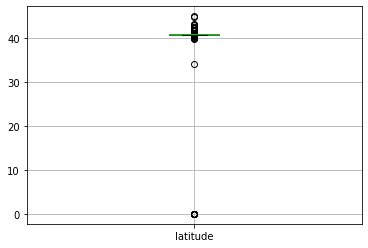

Медианное значение широты =  40.7518


In [10]:
train_df.boxplot('latitude')
plt.show()
print("Медианное значение широты = ", train_df['latitude'].median())

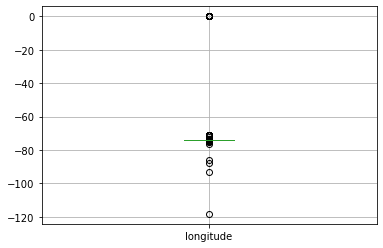

Медианное значение долготы =  -73.9779


In [11]:
train_df.boxplot('longitude')
plt.show()
print("Медианное значение долготы = ", train_df['longitude'].median())

Почти все координаты расположены около значений (40.7518, -73.9779), но есть явно выбивающиеся значения.
Для Нью-Йорка 1 градус широты примерно равен 111км на местности, а 1 градус долготы около 84км. Поэтому выбросами будем считать значения, отклоняющиеся от медианного больше чем на 1 градус. Посмотрим на все выбросы.

In [12]:
display(train_df[train_df['latitude'] < 39.75])
display(train_df[train_df['latitude'] > 41.75])

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
2028,1.0,1,1490317c3a31185f0c8115f01d1acc5b,2016-05-31 22:26:06,Gorgeous one bedroom in Sunset Park-Private en...,"Sunset Park, Brooklyn","[hardwood floors, own entrance, oak cabinets]",0.0000,7087715,0.000,2290f91e45472ecaf0983c5af18098ce,[https://photos.renthop.com/2/7087715_mb_3517f...,1750,145 28 Street,low
37426,1.0,1,0,2016-06-01 19:59:46,Big 2 bedroom in clean and quite multi family ...,88 van Sicklen street,"[Reduced Fee, Cats Allowed]",0.0000,7094527,0.000,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7094527_mb_7f196...,1725,Van Sicklen street,low
39134,1.0,2,a1b2bd0758c6f14be815e4d9382b8169,2016-06-16 15:38:11,Flatiron Duplex!At the intersection of Flatiro...,"Flatiron, Kips Bay, Gramercy","[Views, No Fee, Duplex, Laundry in Unit, Cats ...",0.0000,7174094,0.000,42cb18c3898c42b7512065e7d3e1e8bd,[https://photos.renthop.com/2/7174094_mb_e3c7e...,4395,219 E 28th,low
39798,1.0,1,117aceb94c48bfd1f3066a22f999705f,2016-06-17 02:10:25,NO FEE 1 bedroom - Great Elevator - Laundry B...,"E 38th St,","[Elevator, Walk in Closet(s), High Ceilings, H...",34.0126,7174857,-118.271,f19288238987b18a693e16ee23720c20,[https://photos.renthop.com/2/7174857_6d71b6e1...,2425,"234 E 38th St,",low
46941,1.0,2,8f837ada8d7ec5d251a369cd5909af7c,2016-05-07 08:15:32,Spacious and bright 2 bedroom fully renovated ...,Madison Ave,"[Laundry in Unit, Roof Deck, <null>]",0.0000,6981091,0.000,b93b333035403fc090fb51372fb082f9,[https://photos.renthop.com/2/6981091_mb_efd73...,2950,1632 Madison Ave,medium
49884,1.0,2,ebb1fe8e32b8565f057a20abc495a2b5,2016-05-10 10:25:19,"New construction, luxury highrise, The two bed...",24th St LIC,"[Doorman, Fitness Center, Laundry in Unit, Cat...",0.0000,6991620,0.000,dd85ae9242e4012be8a386d37c1d9453,[https://photos.renthop.com/2/6991620_mb_e7c05...,3619,41-42 24th St,low
63688,4.0,3,f389c8eb16e5d0c771615fb30f3cc9d6,2016-05-11 18:07:15,"This high floor, mint condition, corner unit b...",450 East 83rd Street apt 21D (Furnished),"[Furnished, Laundry In Unit, Cats Allowed, Dog...",0.0000,6997950,0.000,355ccd9223a7481c5d223d39b4e65e90,[https://photos.renthop.com/2/6997950_4ef02f8c...,16500,450 East 83rd Street,low
66197,1.0,1,4d7c804afea366c666731bee9c56919e,2016-05-10 14:30:12,NO FEE! Spacious one bedroom apartment in a F...,west 87,"[Doorman, Fitness Center, No Fee, Cats Allowed...",0.0000,6991901,0.000,7d4f285c15b11c61bacfbf8e7a49252d,[https://photos.renthop.com/2/6991901_mb_e3232...,3600,247 west 87,low
69423,1.0,2,55ab81a4ccd5ea862fba344dc29f1463,2016-05-24 17:43:39,Fantastic 2 bed with the works! It has 2 queen...,118 W 109th,"[Cats Allowed, Dogs Allowed, No Fee, Laundry i...",0.0000,7062134,0.000,91c09ae8bfdc7e5ba7d6385e33a6064d,[https://photos.renthop.com/2/7062134_mb_9f18c...,3200,118 W 109th,low
70841,1.0,1,09e6efa1a58a3cd753aeee80bdf5ec36,2016-05-10 10:11:20,No fee! Prime NOLITA neighborhood with amazing...,Mott St,"[No Fee, <null>]",0.0000,6991613,0.000,dd85ae9242e4012be8a386d37c1d9453,[https://photos.renthop.com/2/6991613_mb_b7cec...,3495,246 Mott St,low


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
872,1.0,2,de47025fe5e6d20a1360cb3efe8c8348,2016-06-11 06:44:25,"Spacious two bedroom, corner unit with...",32 Garrison Street,"[Elevator, Cats Allowed, Dogs Allowed]",42.3459,7143730,-71.0794,c090563865adf7dd1c953e9d6bd65318,[https://photos.renthop.com/2/7143730_775991d2...,4186,32 Garrison Street,low
4719,2.0,2,51052daba3eae7ee4e27bf436f7eb5a9,2016-06-27 02:48:10,Super Spacious Renovated 2BR/2BATH with Home O...,84 Street,"[Private Outdoor Space, Dishwasher, Hardwood F...",42.8724,7221153,-73.4662,5856ea690d343df5f3bc66315babb280,[https://photos.renthop.com/2/7221153_0160c1e4...,2300,1844 84 Street,low
16405,1.0,0,23b17bf6f7be64e3272b561cc0b65f5a,2016-06-22 23:17:24,,Riverside Dr/ 90 Street,"[Furnished, Common Outdoor Space, Air Conditio...",44.6038,7202226,-75.1773,7a3570a25df3d87f6520bfe770473d58,[https://photos.renthop.com/2/7202226_a5b38334...,1350,Riverside Dr/ 90 Street,medium
18267,1.0,2,0,2016-06-29 02:30:45,"Huge bedrooms, windows in every room! Hard woo...",1st Ave. Loop,"[Elevator, Laundry in Building, Dishwasher, Ha...",43.0346,7229074,-76.6336,f44a6215f74f901ac7e326207f2984f7,[https://photos.renthop.com/2/7229074_14de73ea...,3300,250 1st Ave. Loop,low
24747,1.0,1,253df0eb4ce61b5bcb695a440606c58d,2016-06-12 03:46:05,Stunning one bedroom apartment with dr...,56 St. Botolph Street,"[Elevator, Cats Allowed, Dogs Allowed]",42.3459,7146153,-71.0794,6a393c2a7ce242d016fb0170ed19aa61,[https://photos.renthop.com/2/7146153_6c1b933d...,4123,56 St. Botolph Street,low
39046,1.0,1,2adec6e74a834940cde0f05a8684d08f,2016-06-16 04:28:15,Lenox Farms Apartments & Town Homes of...,550 Liberty Street,"[Fitness Center, Cats Allowed, Dogs Allowed]",42.2019,7169135,-70.9846,50ef6c51bfe99f33e459ab902190e87f,[https://photos.renthop.com/2/7169135_9a47ffdd...,2140,550 Liberty Street,low
41022,2.0,2,2adec6e74a834940cde0f05a8684d08f,2016-06-24 05:28:35,Lenox Farms Apartments & Town Homes of...,550 Liberty Street,"[Fitness Center, Cats Allowed, Dogs Allowed]",42.2019,7209113,-70.9846,43389561311270c553bb83a168a07a6b,[https://photos.renthop.com/2/7209113_f37eb785...,2709,550 Liberty Street,low
57131,1.0,1,2adec6e74a834940cde0f05a8684d08f,2016-05-28 03:50:27,Lenox Farms Apartments & Town Homes of...,550 Liberty Street,"[Fitness Center, Cats Allowed, Dogs Allowed]",42.2019,7079426,-70.9846,43389561311270c553bb83a168a07a6b,[https://photos.renthop.com/2/7079426_dc48b760...,2308,550 Liberty Street,low
62409,1.0,1,3dd500218fd52811b282f5af28a0961f,2016-05-06 04:27:33,Vacant,300 2nd Avenue,"[Elevator, Fitness Center, Cats Allowed, Dogs ...",42.3033,6974621,-71.2133,602fee16546f42bfa81f4adc05261cfa,[https://photos.renthop.com/2/6974621_11136b2c...,2889,300 2nd Avenue,low
72896,1.0,0,2fc165040867a7c3694de4b4a63b1062,2016-05-07 10:34:35,Bright UES studio apartment! Only two flights ...,E 78th St between First and York,[],41.7530,6981117,-87.6134,ee89e559c627af61e8730ea4ad7011d6,[https://photos.renthop.com/2/6981117_2428e796...,2000,452 E 78th St #2A (First Ave & York Ave),low


Есть определенное количество объявлений с широтой больше 42, которые соответствуют Бостону. Удалим эти объявления.

Объявления с нулевыми координатами, судя по адресам, все в Нью-Йорке. Заменим их координаты на моду по всем объявлениям.

In [13]:
train_df = train_df.query("latitude < 41.75")

In [14]:
train_df.loc[train_df.latitude < 39.75, 'longitude'] = train_df['longitude'].mode()[0]
train_df.loc[train_df.latitude < 39.75, 'latitude'] = train_df['latitude'].mode()[0]

In [15]:
display(train_df[train_df['longitude'] < -75])
display(train_df[train_df['longitude'] > -73])

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
104822,1.0,0,437454e6d44ae7c94f60b1b6507d084a,2016-04-16 02:10:48,NEWLY RENOVATED BEAUTIFUL SPACIOUS HUGE STUDIO...,"E 46th St,","[Doorman, Elevator, Walk in Closet(s), High Ce...",39.8395,6881361,-86.1527,8439c2c1ab6949a7447b00971e2f73a9,[https://photos.renthop.com/2/6881361_f8efe79e...,2650,"235 E 46th St,",low
114028,1.0,1,6869a3c2a96003e9992d6cd1c3c4b299,2016-04-07 01:41:55,Come for the studio apartment but stay for all...,Modern Studio in Amenity Filled 24 Hr. DM Bldg.,"[Cats Allowed, Dogs Allowed, Doorman, Elevator...",40.0450,6836479,-75.5214,c3b7c269756b10a84641f04868f30db1,[https://photos.renthop.com/2/6836479_2a5daff5...,2895,271 West 47TH Street,low


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
17977,4.5,5,7a85008dcef07df0a46dd3a03f76252b,2016-06-06 01:20:23,<p class='MsoNormal'>Perched atop a bluff on a...,Bluff Road,"[Swimming Pool, Furnished]",40.9697,7114598,-72.1336,61cc4d884e6cfafed2000b1282db7cdb,[https://photos.renthop.com/2/7114598_86f50e55...,25000,336 Bluff Road,low


Оставшиеся выбросы по долготе удалим.

In [16]:
train_df = train_df.query("-73 > longitude > -75")

4. **price**

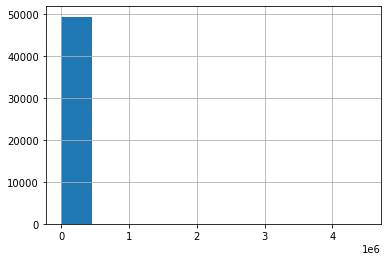

In [17]:
train_df['price'].hist()
plt.show()

In [18]:
train_df['price'].describe()

count    4.932600e+04
mean     3.828256e+03
std      2.207088e+04
min      4.300000e+01
25%      2.500000e+03
50%      3.150000e+03
75%      4.100000e+03
max      4.490000e+06
Name: price, dtype: float64

Удалим выбросы и построим ещё раз

In [19]:
train_df = train_df.query("price < 15000")

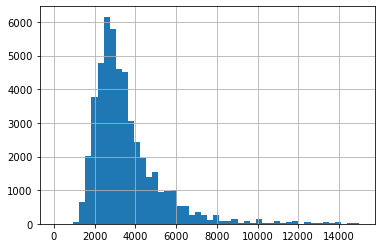

In [20]:
train_df['price'].hist(bins=50)
plt.show()

5. **photos**

На основе фотографий создадим количественный признак "количество фотографий"

In [21]:
train_df["n_photos"] = train_df["photos"].apply(len)
test_df["n_photos"] = test_df["photos"].apply(len)

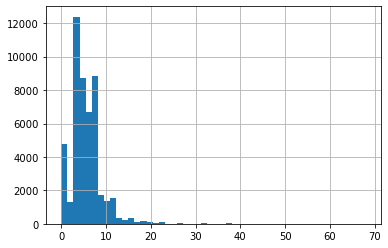

In [22]:
train_df["n_photos"].hist(bins=50)
plt.show()

В основном в объявлениях не больше 20 фотографий, но есть объявления, где фотографий больше. Для обучения модели удалим сильные выбросы.

In [23]:
train_df = train_df.query("n_photos < 30")

6. **features**

Так же, как и с фотографиями, создадим признак "количество удобств"

In [24]:
train_df["n_features"] = train_df["features"].apply(len)
test_df["n_features"] = test_df["features"].apply(len)

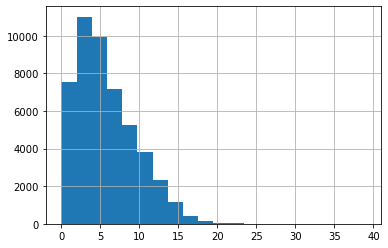

In [25]:
train_df["n_features"].hist(bins=20)
plt.show()

Ограничим количество удобств в квартире 25.

In [26]:
train_df = train_df.query("n_features < 25")

7. **discription**

Зададим признак длины описания квартиры "количество слов в описании"

In [27]:
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

8. **manager_id**

In [28]:
managers = train_df.pivot_table(values='bedrooms', index='manager_id', columns='interest_level', aggfunc='count').fillna(0)
managers.columns = ['high', 'low', 'medium']
managers['count'] = train_df.groupby('manager_id').count()['bedrooms']

In [29]:
managers.head()

,high,low,medium,count
manager_id,,,,
0000abd7518b94c35a90d64b56fbf3e6,0.0,4.0,8.0,12
001ce808ce1720e24a9510e014c69707,0.0,10.0,0.0,10
003fc4e9a70053082f131b1054966aaf,0.0,1.0,0.0,1
00607a02f6efd9c6c7c588826e471ee9,0.0,0.0,2.0,2
00995ff28d79127ed2dca8320e9e7d09,0.0,2.0,1.0,3


In [30]:
def means(row):
    row['high'] = row['high']/row['count']
    row['low'] = row['low']/row['count']
    row['medium'] = row['medium']/row['count']
    return row

In [31]:
managers = managers.apply(means, axis=1)
managers['manager_skill'] = managers['high']*2 + managers['medium']
managers = managers.query('count >= 15')
mean_skill = managers['manager_skill'].mean()
managers = managers['manager_skill']
managers = managers.reset_index()

In [32]:
managers.head()

,manager_id,manager_skill
0,0176ff9c2592a72403fca7904a582345,0.222222
1,0246857142b0b3318d5b518f05bca11b,0.000000
2,0299c9da66d8302ccb5f9d43b877150e,0.800000
3,02c121bbdb886138684baa6863b112fa,0.133333
4,02e17b21a1814fb10336b2ee8ceb3e79,0.535294


In [33]:
train_df = train_df.merge(managers, how='left', on='manager_id')
train_df = train_df.fillna(mean_skill)

In [34]:
test_df = test_df.merge(managers, how='left', on='manager_id')
test_df = test_df.fillna(mean_skill)

### Категориальные признаки

В качестве категориальных признаков у нас имеются building_id и manager_id, но мы так же отнесем к категориальным признакам название улицы display_address.

Посмотрим на количество уникальных значений для для каждого из признаков

In [35]:
cat_features = ["building_id", "manager_id", "display_address"]

In [36]:
print(len(train_df['building_id'].unique()))
print(len(train_df['manager_id'].unique()))
print(len(train_df['display_address'].unique()))

7513
3453
8760


Значений достаточно много, если использовать One Hot Encoder, то будет очень много признаков. Поэтому используем Ordinal Encoder.

In [37]:
categorical_train = train_df[["building_id", "manager_id", "display_address"]]
categorical_test = test_df[["building_id", "manager_id", "display_address"]]
fit_df = pd.concat([categorical_test, categorical_train])

In [38]:
enc = OrdinalEncoder()
enc.fit(fit_df)

OrdinalEncoder()

In [39]:
train_enc = pd.DataFrame(enc.transform(categorical_train),
                            columns=categorical_train.columns)
test_enc = pd.DataFrame(enc.transform(categorical_test),
                            columns=categorical_test.columns)

In [40]:
for f in cat_features:
    train_df[f] = train_enc[f]
    test_df[f] = test_enc[f]

### Дата

Переведем дату в подходящий формат и создадим признаки "месяц публикации", "день публикации" и "час публикации"

In [41]:
train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])

train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour

In [42]:
display(train_df.info())
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48865 entries, 0 to 48864
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   bathrooms              48865 non-null  float64       
 1   bedrooms               48865 non-null  int64         
 2   building_id            48865 non-null  float64       
 3   created                48865 non-null  datetime64[ns]
 4   description            48865 non-null  object        
 5   display_address        48865 non-null  float64       
 6   features               48865 non-null  object        
 7   latitude               48865 non-null  float64       
 8   listing_id             48865 non-null  int64         
 9   longitude              48865 non-null  float64       
 10  manager_id             48865 non-null  float64       
 11  photos                 48865 non-null  object        
 12  price                  48865 non-null  int64         
 13  s

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 74658
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   bathrooms              74659 non-null  float64       
 1   bedrooms               74659 non-null  int64         
 2   building_id            74659 non-null  float64       
 3   created                74659 non-null  datetime64[ns]
 4   description            74659 non-null  object        
 5   display_address        74659 non-null  float64       
 6   features               74659 non-null  object        
 7   latitude               74659 non-null  float64       
 8   listing_id             74659 non-null  int64         
 9   longitude              74659 non-null  float64       
 10  manager_id             74659 non-null  float64       
 11  photos                 74659 non-null  object        
 12  price                  74659 non-null  int64         
 13  s

None

### Текстовые признаки

Зададим признаки на основе имеющихся удобств в квартирах. Для этого создадим корпус из слов, встречающихся в столбце features, посчитаем tf-idf для каждого слова и зададим эти значения как признаки для модели.

За реализацию идеи спасибо SRK в своём ноутбуке [XGB starter in python](https://www.kaggle.com/sudalairajkumar/xgb-starter-in-python)

In [43]:
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
display(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

0    Dining_Room Pre-War Laundry_in_Building Dishwa...
1    Doorman Elevator Laundry_in_Building Dishwashe...
2    Doorman Elevator Laundry_in_Building Laundry_i...
3                                                     
4    Doorman Elevator Fitness_Center Laundry_in_Bui...
Name: features, dtype: object

## Обучение модели

In [44]:
train_df.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level',
       'n_photos', 'n_features', 'num_description_words', 'manager_skill',
       'created_month', 'created_day', 'created_hour'],
      dtype='object')

In [45]:
features_to_use = ['bathrooms', 'bedrooms', 'building_id', 'display_address', 'latitude', 'manager_skill', 
                   'longitude', 'manager_id', 'price', 'n_photos', 'n_features', 'num_description_words', 
                   'created_month', 'created_day', 'created_hour']

In [46]:
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

(48865, 215) (74659, 215)


In [47]:
%%time

model = LGBMClassifier(random_state=123)
params = {'max_depth': np.arange(5, 10, 2), 'n_estimators': np.arange(100,151,10)}
grid = GridSearchCV(model, params, scoring='neg_log_loss', cv=2)
grid.fit(train_X, train_y)

print('Комбинация параметров, которая дает лучший результат:', grid.best_params_)
print(f'Минимальный log_loss: {abs(grid.best_score_):.6f}')

Комбинация параметров, которая дает лучший результат: {'max_depth': 7, 'n_estimators': 120}
Минимальный log_loss: 0.558931
Wall time: 27.8 s


In [48]:
model = LGBMClassifier(max_depth = 7, n_estimators=120, random_state=123)
model.fit(train_X, train_y)

pred = model.predict_proba(test_X)

In [49]:
result = pd.DataFrame(pred)
result.columns = ["high", "medium", "low"]
result["listing_id"] = test_df.listing_id.values
result.to_csv(r'C:\Users\leoci\Desktop\two_sigma.csv', index=False)